In [1]:
import numpy as np
import pandas as pd
from data_manager import get_substring, load_metadata
from score import ProbabilityToScore
from columns_desc import columns_dict
from fast_ml.model_development import train_valid_test_split
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder
from preprocessors import TemporalVariableTransformerDays, TemporalVariableTransformerYears
# from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import plot_importance
import shap
from yellowbrick.classifier import (
    ClassificationReport,
    DiscriminationThreshold,
    ROCAUC
)


pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [2]:
df = pd.read_csv('/Users/ronsnir/Documents/postpay/data/behaviour_mature_at_due_df_v2.csv')
df.drop(columns=["customer_date_joined"], inplace=True)

In [3]:
df.shape

(17814, 36)

In [4]:
for u in ['unpaid_at_due', 'unpaid_at_5', 'unpaid_at_10', 'unpaid_at_20', 'unpaid_at_30', 'unpaid_at_60', 'unpaid_at_90']:
    mature_df = df[pd.notnull(df[u])]
    print(f"{u}: {(mature_df[u].sum() / mature_df['total_amount'].sum()) * 100}")

unpaid_at_due: 10.729006529617143
unpaid_at_5: 5.067389409679074
unpaid_at_10: 3.695931107174113
unpaid_at_20: 2.4963436373615173
unpaid_at_30: 1.9480353019872592
unpaid_at_60: 1.4724386685465134
unpaid_at_90: 1.0254102911452543


In [5]:
# Drop irrelevant unpaid columns
unpaid_at_30_df = df[pd.notnull(df['unpaid_at_30'])].drop(columns=['unpaid_at_due', 'unpaid_at_5', 'unpaid_at_10', 'unpaid_at_20', 'unpaid_at_60', 'unpaid_at_90'])
# Drop more irrelevant columns
unpaid_at_30_df = unpaid_at_30_df.drop(columns=["count_paid_orders", "count_unpaid_orders", "count_paid_instalments", "count_unpaid_instalments", "days_since_last_unpaid", "avg_fees_per_order_180d", "avg_fees_per_order_90d", "avg_fees_per_order_30d"])
# Keep only returning customers (and drop the is_returning column)
returning_df = unpaid_at_30_df[unpaid_at_30_df['is_returning'] == True].drop(columns=['is_returning'])
# Convert unpaid_at_30 to be classifier (1 when unpaid_at_30 is bigger than 0, 0 otherwise)
returning_df['unpaid_at_30'] = np.where(returning_df['unpaid_at_30'] > 0, 1, 0)
# Remove Shopping App orders
browser_df_df = returning_df[~returning_df['checkout_type'].isin(['postpay-card'])]
# Fetch the device type from user_agent variable (and drop the user_agent column)
browser_df_df['user_agent_type'] = browser_df_df['user_agent'].apply(lambda row: get_substring(row, strings_list = ['iPhone', 'Windows NT', 'Macintosh', 'Android'])) # Maybe in the pipeline
browser_df_df.drop(columns=['user_agent'], inplace=True)
returning_unpaid_at_30_df = browser_df_df.copy()

In [6]:
returning_unpaid_at_30_df['unpaid_at_30'].mean()*100

2.5338424158278374

# Start the research

In [7]:
returning_unpaid_at_30_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5762 entries, 84 to 17812
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   instalment_plan_id            5762 non-null   int64  
 1   customer_id                   5762 non-null   float64
 2   order_id                      5762 non-null   int64  
 3   created                       5762 non-null   object 
 4   payment_method_brand          5762 non-null   object 
 5   payment_method_expires        5762 non-null   object 
 6   merchant_name                 5762 non-null   object 
 7   checkout_type                 5762 non-null   object 
 8   payment_method_type           5762 non-null   object 
 9   nr_of_items                   5762 non-null   float64
 10  unpaid_at_30                  5762 non-null   int64  
 11  total_amount                  5762 non-null   float64
 12  avg_order_value               4244 non-null   float64
 13  a

In [8]:
date_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["date"]]
num_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["integer", "numeric"]]
cat_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["categorical"]]
id_cols_list = [c for c in columns_dict if columns_dict[c]["class"] in ["id"]]

In [9]:
returning_unpaid_at_30_df[date_cols_list] = returning_unpaid_at_30_df[date_cols_list].astype('M')
returning_unpaid_at_30_df[num_cols_list] = returning_unpaid_at_30_df[num_cols_list].astype('f')
returning_unpaid_at_30_df[cat_cols_list] = returning_unpaid_at_30_df[cat_cols_list].astype('O')
# returning_unpaid_at_30_df[date_cols_list] = returning_unpaid_at_30_df[date_cols_list].astype('M')
# https://numpy.org/doc/stable/reference/arrays.dtypes.html

In [10]:
returning_unpaid_at_30_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5762 entries, 84 to 17812
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   instalment_plan_id            5762 non-null   int64         
 1   customer_id                   5762 non-null   float64       
 2   order_id                      5762 non-null   int64         
 3   created                       5762 non-null   datetime64[ns]
 4   payment_method_brand          5762 non-null   object        
 5   payment_method_expires        5762 non-null   datetime64[ns]
 6   merchant_name                 5762 non-null   object        
 7   checkout_type                 5762 non-null   object        
 8   payment_method_type           5762 non-null   object        
 9   nr_of_items                   5762 non-null   float32       
 10  unpaid_at_30                  5762 non-null   float32       
 11  total_amount                

# Analysis

## Target

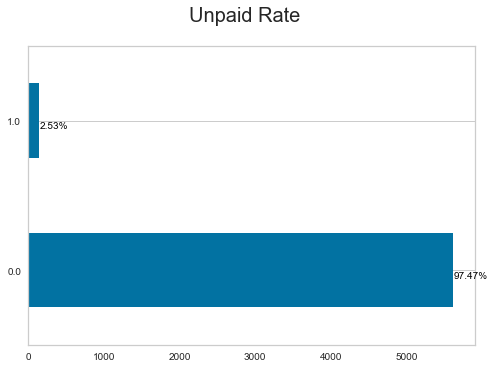

In [11]:
ax = returning_unpaid_at_30_df["unpaid_at_30"].value_counts().plot(kind="barh")
totals = [i.get_width() for i in ax.patches]
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle("Unpaid Rate", fontsize=20)
plt.show()

In [12]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in returning_unpaid_at_30_df.columns if returning_unpaid_at_30_df[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

returning_unpaid_at_30_df[vars_with_na].isnull().mean().sort_values(ascending=False)*100

count_open_orders          99.982645
avg_order_value            26.345019
avg_fees_per_order_365d    26.345019
date_of_birth               8.035404
sum_paid_amount             2.273516
user_agent_type             0.329747
dtype: float64